# DGM Lab 3 - Variational Autoencoders

In this Lab, we will build and train latent variable models using the Variational Autoencoder framework.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


 ## Variational Autoencoders
 
 A variational autoencoder consists of a likelihood model, or decoder $p_\theta(x| z)$, and an approximate posterior model, or encoder $q(z | x)$.
 
 ### Assignment 1
 
 We will build a Variational Autoencoder for modelling MNIST digits. As you recall from Lab 1, MNIST digits are 28x28 binary images of handwritten digits. Build an `Encoder` and `Decoder` class as Pytorch `nn.Module`s, which represent $q(z | x)$ and $p_\theta(x| z)$. Parameterize the latent space $z$ as a multivariate Gaussian with diagonal covariance matrix. A simple architecture will suffice, for example a 2 hidden layer fully connected neural network. For now, limit the latent space to two dimensions, so we can visualize and investigate the learnt manifold later.
 
 Think how to parameterize the outputs of each model. For example, a Gaussian can be parameterized by means and standard deviations, or means and variance, or mean and log variance, ... Similarly the likelihood model should model a distribution over pixels. Which distribution seems appropriate for binary pixels?

In [4]:
# Difficult part
# Model q(z|x). For this map vector z to mean and std of Gaussian distribution
class Encoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Encoder, self).__init__()
        #Two hidden layers fully connected
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 256)
        #Mean and std of Gaussian distribution
        self.fc31 = nn.Linear(256, latent_dim)
        self.fc32 = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc31(x)
        std = torch.exp(self.fc32(x)/2)  # sqrt(var) = exp(log(var)/2) = sqrt(exp(log(var)))
        return mean, std


In [5]:
# Easy part
# Likelihood model. From z, where z=mu+sigma*epsilon, want p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Decoder, self).__init__()
        #Two hidden layers fully connected
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 784)      # Output dim 28*28=784

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = torch.sigmoid(self.fc3(z))
        return z

In [6]:
# Complete model, build it before knowing we needed a separate sample method
# Bottleneck, sample z from q(z|x) and then compute p(x|z)
class VAE(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=256):
        super(VAE, self).__init__()
        self.mu, self.sigma = Encoder(latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, hidden_dim)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)  # Saw on the internet you can move the samples to GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0


    def forward(self, x):
        # Sample z from q(z|x)
        mu, sigma = self.encoder(x)
        # Reparametrization trick
        z = mu + sigma * self.N.sample(mu.shape)    # z = mu + sigma * epsilon, sample from N(0,1)
        x_recon = self.decoder(z)
        return z, mu, sigma, x_recon

To test your classes, load the MNIST dataset, and forward a batch of data through the `Encoder`. Similarly, create a batch of $z$ tensors, forward these through the `Decoder` and plot the results.

In [7]:
# Load MNIST dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

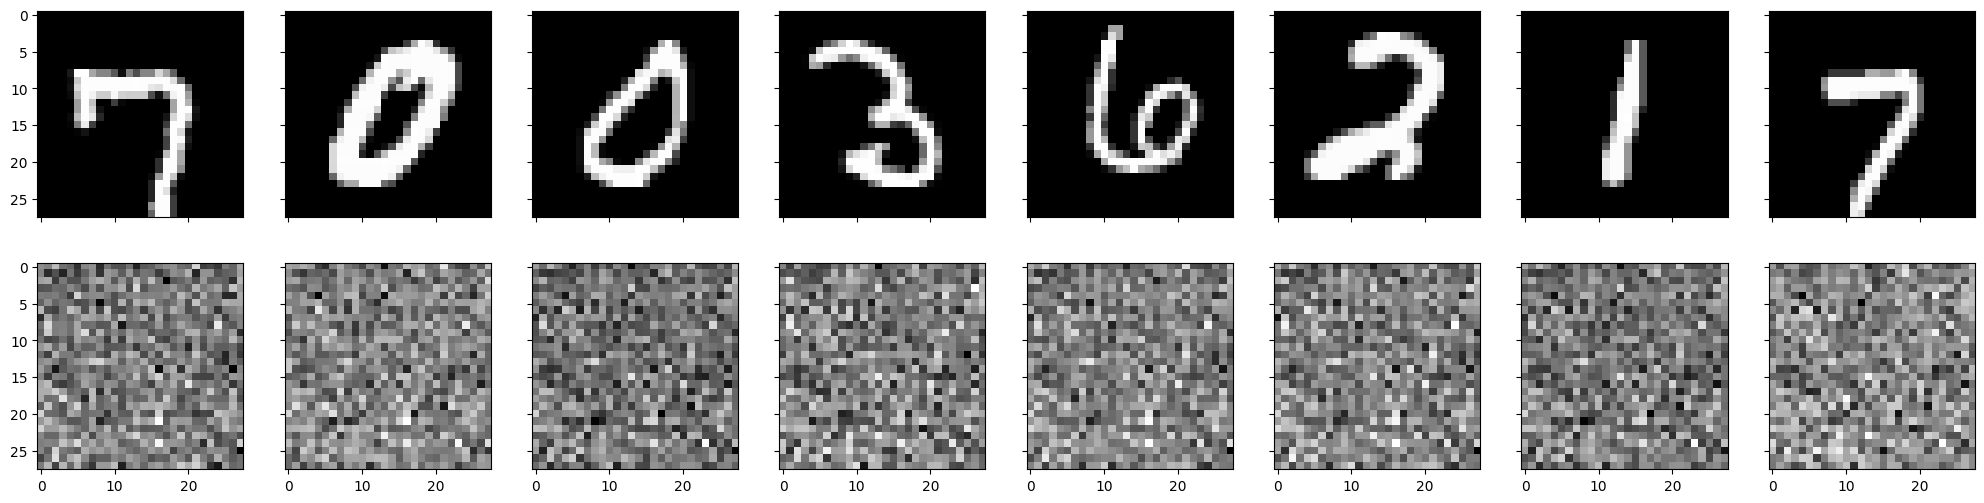

In [8]:
# Not utilizing GPU
# Forward batch of data trough encoder
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
vae = Encoder(2, 256)

data_iter = iter(train_loader)
images, labels = next(data_iter)
mu, sigma = vae(images)

# Batch of random z tensors
z = torch.randn(32, 2)

# Forward batch of z tensors trough decoder
decoder = Decoder(2, 256)
x_recon = decoder(z)

# Plot
fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(25,6))
for i in range(8):
    axes[0,i].imshow(images[i].view(28, 28), cmap='gray')
    axes[1,i].imshow(x_recon[i].view(28, 28).detach(), cmap='gray')
plt.show()


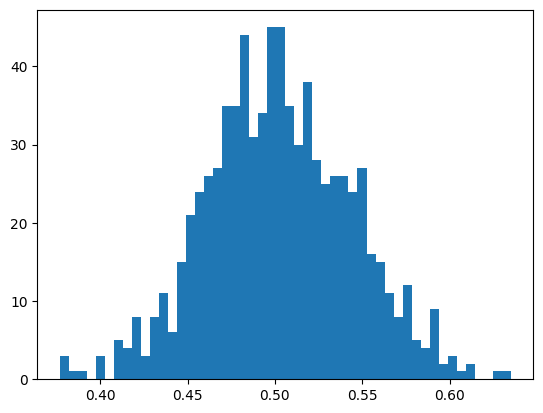

In [9]:
plt.hist(x_recon[0].view(28*28).detach(), bins=50)
plt.show()

To train the Variational Autoencoder end-to-end with stochastic gradient descent, we need to sample from the posterior distribution in a differentiable way. Implement a `sample()` method that recieves as argument (a batch of) parameters of the posterior distribution, and returns (a batch of) samples using the reparameterization trick.

In [10]:
# Reparametrization trick
# For backprop need to sample from q(z|x) in differentiable way
def sample(mu, sigma):
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

Now test the whole forward pass: fetch a batch of MNIST images, get the approximate posterior distribution, sample a latent code from this distribution, and reconstruct images using the likelihood model.

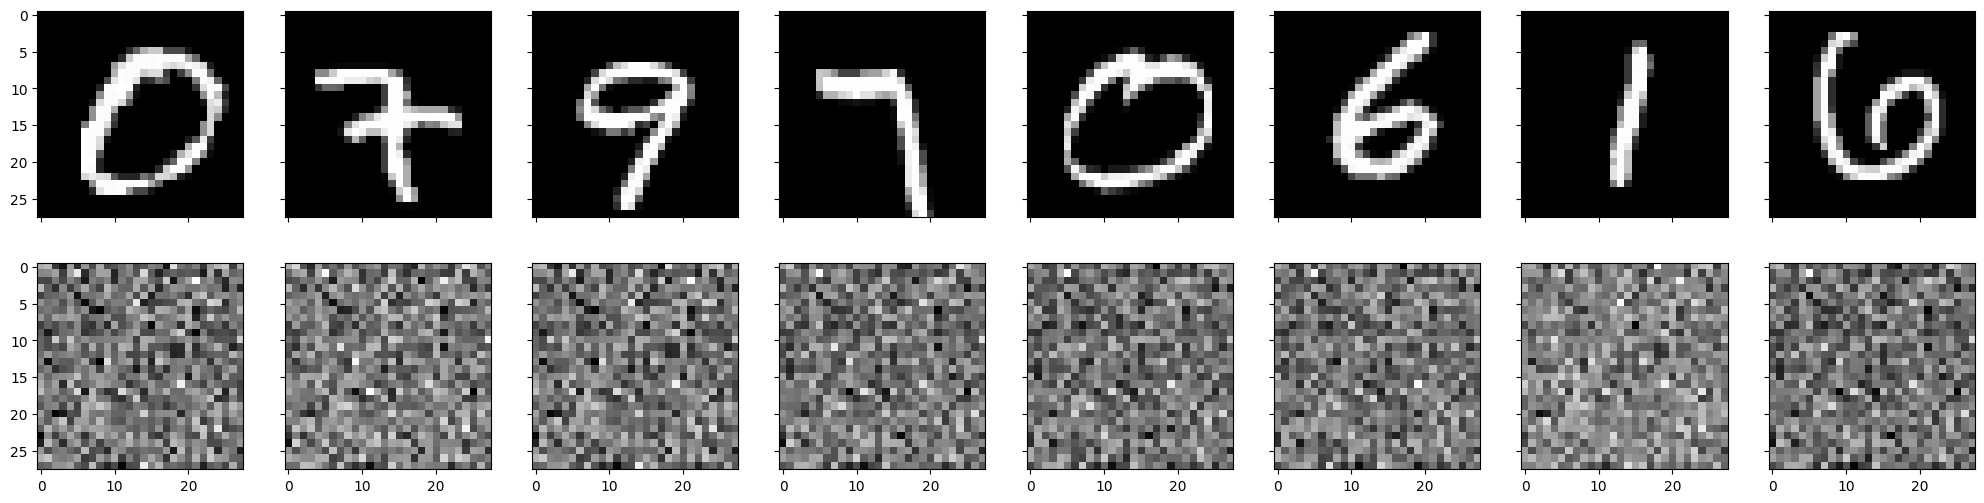

In [11]:
# Not utilizing GPU
# Forward batch of data trough encoder
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
vae = Encoder(2, 256)

data_iter = iter(train_loader)
images, labels = next(data_iter)
mu, sigma = vae(images)

# Batch of z tensors
z = sample(mu, sigma)

# Forward batch of z tensors trough decoder
decoder = Decoder(2, 256)
x_recon = decoder(z)

# Plot
fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(25,6))
for i in range(8):
    axes[0,i].imshow(images[i].view(28, 28), cmap='gray')
    axes[1,i].imshow(x_recon[i].view(28, 28).detach(), cmap='gray')
plt.show()

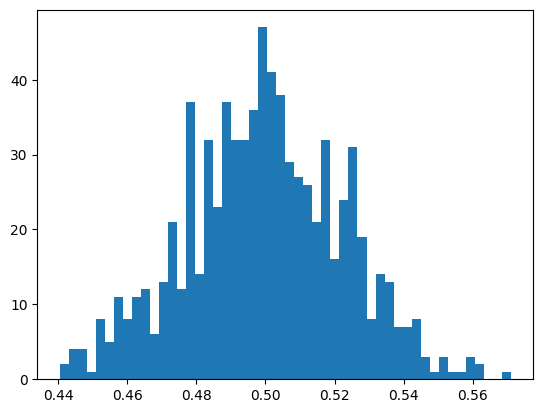

In [12]:
plt.hist(x_recon[0].view(28*28).detach(), bins=50)
plt.show()

* Dont understand what we need to see here, in both cases (random or latent space) the model has not learned the distribution.

### Assignment 2 

Before we can write the train loop, we need to implement the loss function. Variational autoencoders are trained by maximizing the Evidence Lower Bound (ELBO). Define the function `elbo_loss()` that calculates the loss, given a batch of images, latent distributions and reconstructions. The exact implementation will depend on the parameterization of your posterior and likelihood model. Note that if all pixels are modelled as independent, the correct, total log likelihood should be the summation of each term attributed to each pixel.

In [13]:
# Loss function = reconstruction loss + KL divergence
def elbo_loss(x, x_recon, mu, sigma):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')  #In slides MSE loss
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)) #Equation slide 27, sum over latent dim (dim=1)  
    return recon_loss + kl_loss

Now implement the train loop and train both the `Encoder` and `Decoder` jointly. After a few epochs you should already see sensible reconstructions.

In [14]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

encoder = Encoder(2, 256).to(device)
decoder = Decoder(2, 256).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

critereon = elbo_loss

In [15]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        encoder.train(); decoder.train()
        
        images = images.to(device)
        # Forward pass
        mu, sigma = encoder(images)
        mu = mu.to(device)
        sigma = sigma.to(device)

        z = sample(mu, sigma)
        z = z.to(device)

        x_recon = decoder(z)
        x_recon = x_recon.to(device)

        loss = critereon(images, x_recon, mu, sigma)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [100/1875], Loss: 1713.3767
Epoch [1/10], Step [200/1875], Loss: 1616.7412
Epoch [1/10], Step [300/1875], Loss: 1565.7551
Epoch [1/10], Step [400/1875], Loss: 1355.6064
Epoch [1/10], Step [500/1875], Loss: 1294.5193
Epoch [1/10], Step [600/1875], Loss: 1576.0537
Epoch [1/10], Step [700/1875], Loss: 1241.3070
Epoch [1/10], Step [800/1875], Loss: 1478.0760
Epoch [1/10], Step [900/1875], Loss: 1342.2333
Epoch [1/10], Step [1000/1875], Loss: 1133.5491
Epoch [1/10], Step [1100/1875], Loss: 1398.2526
Epoch [1/10], Step [1200/1875], Loss: 1412.0439
Epoch [1/10], Step [1300/1875], Loss: 1400.5012
Epoch [1/10], Step [1400/1875], Loss: 1312.8372
Epoch [1/10], Step [1500/1875], Loss: 1454.0239
Epoch [1/10], Step [1600/1875], Loss: 1285.5764
Epoch [1/10], Step [1700/1875], Loss: 1197.0914
Epoch [1/10], Step [1800/1875], Loss: 1273.5703
Epoch [2/10], Step [100/1875], Loss: 1234.9443
Epoch [2/10], Step [200/1875], Loss: 1164.6699
Epoch [2/10], Step [300/1875], Loss: 1146.1285
Epoc

Let's take a closer look at what the model has learnt. In theory, the likelihood model should have learnt a 2D Gaussian latent manifold for all MNIST digits. To visualize this manifold, sample latent codes on a grid centered around (0,0), and visualize the outputs of the likelihood model.

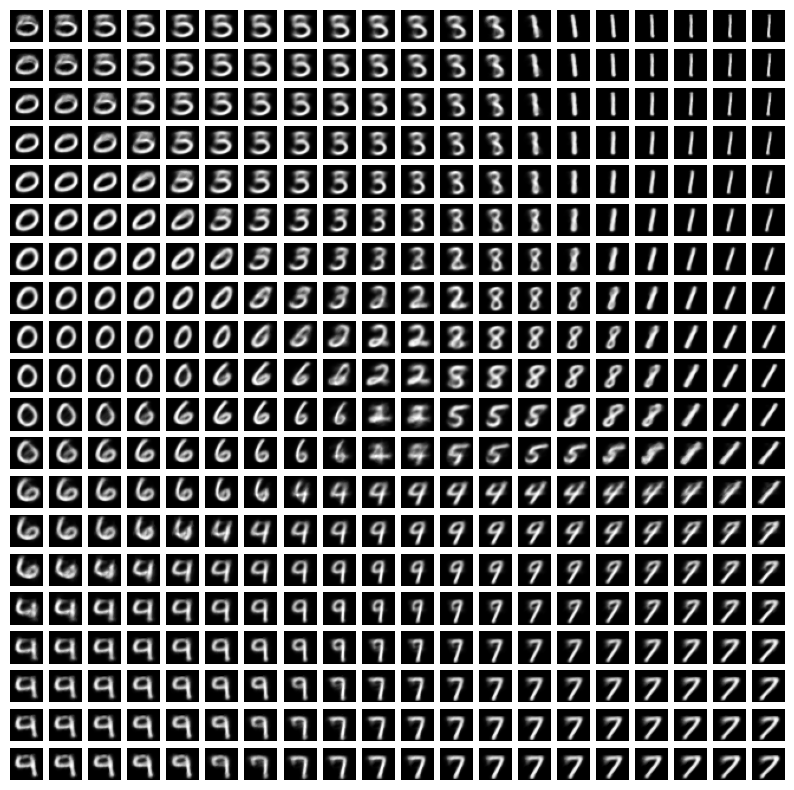

In [16]:
elem = 20
rng = 2.0

# linspace creates an array of elem elements between -range and range 
# this means grid center is at (0,0)
x = np.linspace(-rng, rng, elem)
y = np.linspace(-rng, rng, elem)

# meshgrid creates a grid of x and y
# dstack stacks the x and y grids
z_grid = np.dstack(np.meshgrid(x, y))   #dim = (elem, elem, 2)

z = torch.from_numpy(z_grid).view(-1, 2).float()
z = z.to(device)

decoder.eval()
x_recon = decoder(z)
x_recon = x_recon.cpu()

# Plot the results
fig, ax = plt.subplots(elem, elem, figsize=(10, 10))
for i in range(elem):
    for j in range(elem):
        ax[i, j].imshow(x_recon[i * elem + j].view(28, 28).detach(), cmap='gray')
        ax[i, j].axis('off')
plt.show()

Similarly, we can also encode all MNIST digits from the test set using the approximate posterior model, and plot the means of the resulting posterior distributions on a scatter plot. Use the MNIST digit label as the color for each data point.

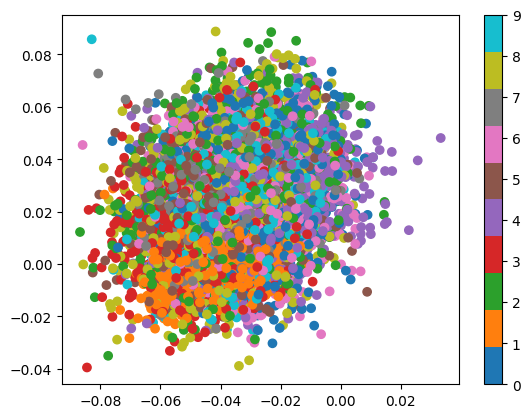

In [17]:
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

encoder = Encoder(2, 256)

means = []
mu_labels = []

for images, labels in test_loader:
    encoder.eval()
    mu, _ = encoder(images)
    means.append(mu.detach().numpy())
    mu_labels.append(labels.detach().numpy())

means = np.concatenate(means, axis=0)
mu_labels = np.concatenate(mu_labels, axis=0)
plt.scatter(means[:,0], means[:,1], c=mu_labels, cmap='tab10')
plt.colorbar()
plt.show()

## The information bottleneck and $\beta$-VAE

The dimensionality of the latent code, as well as the KL term in the ELBO loss regulate the information bottleneck of the Variational Autoencoder. The $\beta$-VAE lets you explicitly tune the pressure of this bottleneck via the loss function.

### Assignment 3

Instantiate a new `Encoder` and `Decoder`, now with a larger latent dimensionality (e.g. 10 latent dimensions). Re-train such a VAE. To get an intuition on what the different latent dimensions encode, create again a grid in which you vary a single latent dimension (e.g. -3 .. 3) in each row. Also increase the capacity of the encoder and decoder by increasing the size of the hidden layers.

In [18]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

encoder = Encoder(10, 512).to(device)
decoder = Decoder(10, 512).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

critereon = elbo_loss

In [19]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        encoder.train(); decoder.train()

        images = images.to(device)
        
        # Forward pass
        mu, sigma = encoder(images)
        mu = mu.to(device)
        sigma = sigma.to(device)

        z = sample(mu, sigma)
        z = z.to(device)

        x_recon = decoder(z)
        x_recon = x_recon.to(device)
        
        loss = critereon(images, x_recon, mu, sigma)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [100/1875], Loss: 1830.2233
Epoch [1/10], Step [200/1875], Loss: 1528.9030
Epoch [1/10], Step [300/1875], Loss: 1423.2385
Epoch [1/10], Step [400/1875], Loss: 1446.0337
Epoch [1/10], Step [500/1875], Loss: 1414.1821
Epoch [1/10], Step [600/1875], Loss: 1269.6096
Epoch [1/10], Step [700/1875], Loss: 1198.5822
Epoch [1/10], Step [800/1875], Loss: 1073.6582
Epoch [1/10], Step [900/1875], Loss: 1110.4388
Epoch [1/10], Step [1000/1875], Loss: 1224.1370
Epoch [1/10], Step [1100/1875], Loss: 1157.1125
Epoch [1/10], Step [1200/1875], Loss: 1204.7590
Epoch [1/10], Step [1300/1875], Loss: 1004.5145
Epoch [1/10], Step [1400/1875], Loss: 1023.2864
Epoch [1/10], Step [1500/1875], Loss: 1166.5664
Epoch [1/10], Step [1600/1875], Loss: 1162.0977
Epoch [1/10], Step [1700/1875], Loss: 1199.4360
Epoch [1/10], Step [1800/1875], Loss: 1129.2067
Epoch [2/10], Step [100/1875], Loss: 1103.2238
Epoch [2/10], Step [200/1875], Loss: 1123.0238
Epoch [2/10], Step [300/1875], Loss: 1135.7271
Epoc

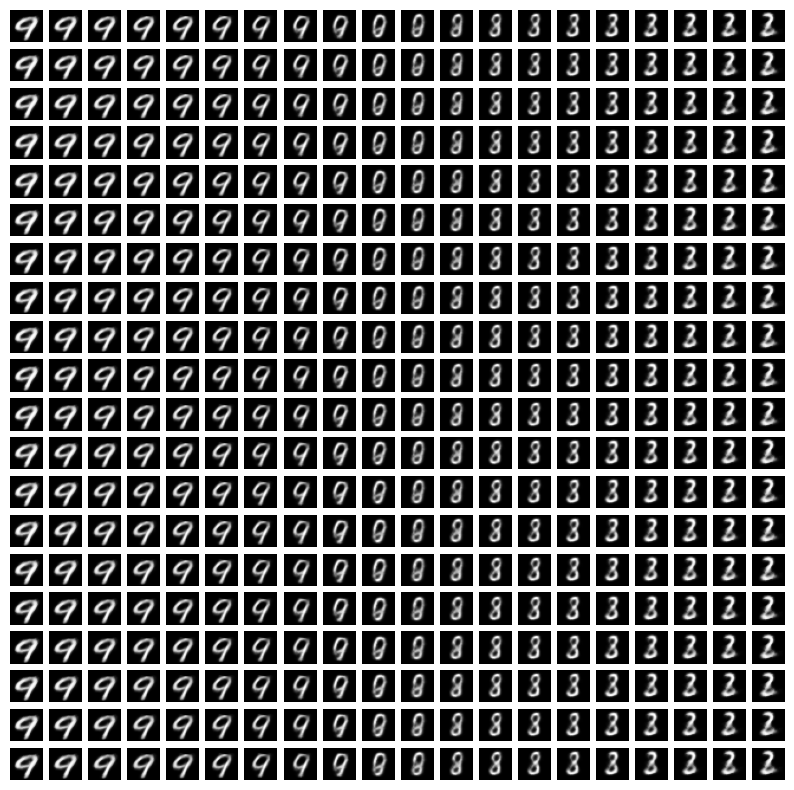

In [20]:
elem = 20
rng = 3.0

# linspace creates an array of elem elements between -range and range 
# this means grid center is at (0,0)
x = np.linspace(-rng, rng, elem)
y = np.linspace(-rng, rng, elem)

# meshgrid creates a grid of x and y
# dstack stacks the x and y grids
z_grid = np.zeros((elem, elem, 10)) 
for i in range(elem):
    z_grid[i, :, 1] = x[i]          #Change third dimension to see different latent dimensions
    z_grid[i, :, 2] = y

z = torch.from_numpy(z_grid).view(-1, 10).float()

z = z.to(device)
decoder.eval()
x_recon = decoder(z)
x_recon = x_recon.cpu()

# Plot the results
fig, ax = plt.subplots(elem, elem, figsize=(10, 10))
for i in range(elem):
    for j in range(elem):
        ax[i, j].imshow(x_recon[i * elem + j].view(28, 28).detach(), cmap='gray')
        ax[i, j].axis('off')
plt.show()

Now change the loss function to add a $\beta$ factor for the KL term. Visualize again the reconstructions and experiment with different $\beta$ values. What is the effect of a higher / lower $\beta$. Can you explain this?

* A beta of 1 is equivalent to the original VAE. As we increase beta, the DKL term becomes more important, This causes the model to learn a more disentangled representation of the data in the latent space because it puts more emphasis on matching the approximate posterior distribution to the prior distribution. However if beta is too high, you will just reproduce the posterior distribution, as the model is encouraged to learn a more disentangled representation of the data at the expense of reconstruction accuracy.
Note that by increasing beta, we will get a more blury representation.

In [21]:
# Loss function = reconstruction loss + KL divergence
def beta_elbo_loss(x, x_recon, mu, sigma, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')  #In slides MSE loss
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)) #Equation slide 27, sum over latent dim (dim=1)  
    return recon_loss + kl_loss*beta

In [22]:
batch_size = 32
beta = 2
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

encoder = Encoder(10, 1025).to(device)
decoder = Decoder(10, 1024).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

critereon = beta_elbo_loss

In [23]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        encoder.train(); decoder.train()

        images = images.to(device)
        
        # Forward pass
        mu, sigma = encoder(images)
        mu = mu.to(device)
        sigma = sigma.to(device)

        z = sample(mu, sigma)
        z = z.to(device)
        print(z.shape)

        x_recon = decoder(z)
        x_recon = x_recon.to(device)
        print(x_recon.shape)
        
        loss = critereon(images, x_recon, mu, sigma, beta)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size([32, 10])
torch.Size([32, 784])
torch.Size(

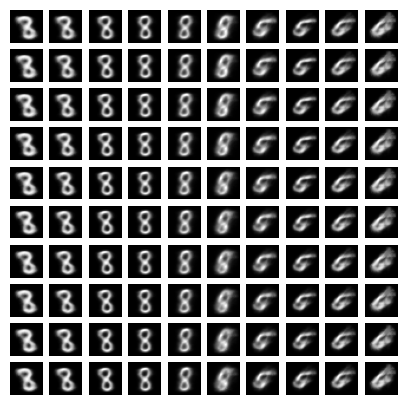

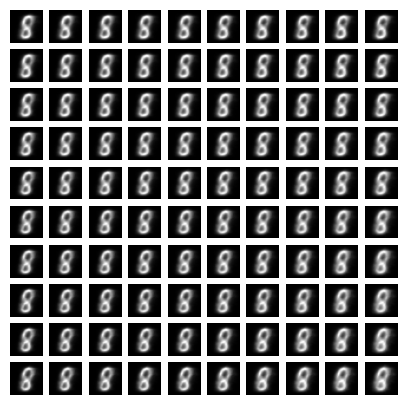

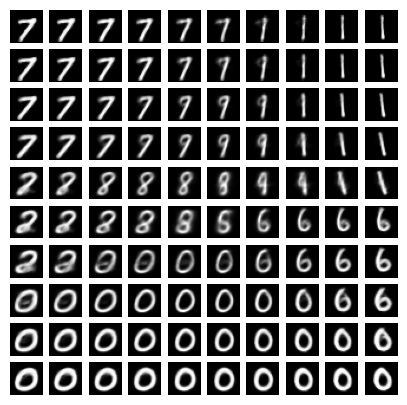

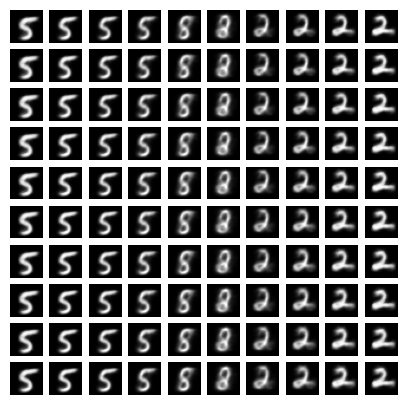

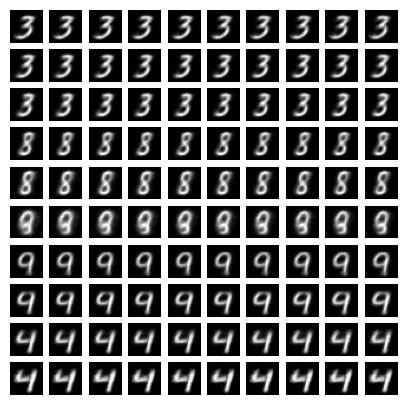

In [24]:
elem = 10
rng = 3.0

x_recon_pairs = []
for n in range(0,10,2):
    # linspace creates an array of elem elements between -range and range 
    # this means grid center is at (0,0)
    x = np.linspace(-rng, rng, elem)
    y = np.linspace(-rng, rng, elem)

    # meshgrid creates a grid of x and y
    # dstack stacks the x and y grids
    z_grid = np.zeros((elem, elem, 10)) 
    for i in range(elem):
        z_grid[i, :, n] = x[i]          #Change third dimension to see different latent dimensions
        z_grid[i, :, n+1] = y

    z = torch.from_numpy(z_grid).view(-1, 10).float()

    z = z.to(device)
    decoder.eval()
    x_recon = decoder(z)
    x_recon_pairs.append(x_recon.cpu())
    #print(x_recon.cpu().shape)

for n in range(5):
    # Plot the results
    fig, ax = plt.subplots(elem, elem, figsize=(5, 5))
    for i in range(elem):
        for j in range(elem):
            ax[i, j].imshow(x_recon_pairs[n][i * elem + j].view(28, 28).detach(), cmap='gray')
            ax[i, j].axis('off')
plt.show()

## Discrete latent spaces

Until now we modelled the latent space as a Gaussian distribution. However, it is clear that at least one factor of variation (i.e. the digit) is inherintly discrete. To address this, we will now use Categorical latent distributions, and apply the reparameterization trick using the Gumbel-Softmax.

### Assignment 4

Create a new `Encoder` and `Decoder`, but now parameterize the latent distribution as a Categorical distribution with $k=10$. Reimplement the sample method to use the Gumbel-Softmax trick for reparameterization, and adjust the loss function (i.e. use a Uniform prior instead of $N(0,1)$). Again, train end-to-end and visualize the resulting latent space. If all goes well you should see that some latent dimensions actually map to a number. However it won't nicely assign each digit class to a latent dimension, due to the unsupervised training and the model capacity. To have better reconstructions, you could try more higher dimensional latent codes, for example 10 Categoricals with each $k=10$, or 100 Bernoulli variables. Another option is to have a mixed discrete and continuous latent space.

In [41]:
# Difficult part
# Model q(z|x). For this map vector z to mean and std of Gaussian distribution
class Cat_Encoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_categories=10):
        super(Cat_Encoder, self).__init__()
        self.latent_dim = latent_dim    
        self.num_categories = num_categories
        #Two hidden layers fully connected
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, latent_dim*num_categories)    

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, self.latent_dim, self.num_categories)    #logits for each category of categorical distribution
        return x

In [42]:
# Easy part
# Likelihood model. From z, where z=mu+sigma*epsilon, want p(x|z)
class Cat_Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_categories=10):
        super(Cat_Decoder, self).__init__()
        #Two hidden layers fully connected
        self.fc1 = nn.Linear(latent_dim*num_categories, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 784)      # Output dim 28*28=784

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = torch.sigmoid(self.fc3(z))
        return z

In [43]:
# Gumbel Softmax
def gs_sample(logits, t):
    U = torch.rand_like(logits)
    y = logits - torch.log(-torch.log(U + 1e-20) + 1e-20)
    y = F.softmax(y.view(-1, 10, 10), dim=-1) / t
    y = y.view(-1, 10*10)
    return y
    #y = logits - torch.log(-torch.log(torch.rand(logits.shape).to(device)))
    #z = F.softmax(y/t, dim=2)
    #return z
    #return F.gumbel_softmax(logits, tau=t, hard=False,dim=-1)
    #b,n,k = logits.shape
    #logits = logits.view(b,n*k)
    #g = torch.distributions.gumbel.Gumbel(0,1)
    #z = F.softmax((logits + g.sample(logits.shape).to(device))/t, dim=-1)
    #return z



In [44]:
# Modification to fit categorical distribution
def cat_elbo_loss(x, x_recon, logits):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon.squeeze(1), x.view(-1, 784), reduction='sum')  #In slides MSE loss
    # KL divergence
    q_y = F.softmax(logits, dim=1)  #Probability q(y)
    log_q_y = F.log_softmax(logits, dim=1)  #Log probability q(y)
    kl_loss = torch.sum(q_y * (log_q_y - torch.log(torch.tensor(1.0/logits.shape[-1]))))  #log(p(y)) = uniform distribution over all categories
    return recon_loss + kl_loss

In [56]:
batch_size = 32
tao = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

encoder = Cat_Encoder(10, 2048, 10).to(device)
decoder = Cat_Decoder(10, 2048).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

critereon = cat_elbo_loss

In [57]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        encoder.train(); decoder.train()

        images = images.to(device)
        #print(images.shape)

        # Forward pass
        logits = encoder(images)
        #print(logits.shape)
        logits = logits.to(device)

        z = gs_sample(logits, tao)
        #print(z.shape)
        z = z.to(device)

        x_recon = decoder(z)
        #print(x_recon.shape)
        x_recon = x_recon.to(device)
        
        loss = critereon(images, x_recon, logits)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [100/1875], Loss: 1503.7677
Epoch [1/10], Step [200/1875], Loss: 1540.0712
Epoch [1/10], Step [300/1875], Loss: 1189.3966
Epoch [1/10], Step [400/1875], Loss: 1343.7396
Epoch [1/10], Step [500/1875], Loss: 1106.9288
Epoch [1/10], Step [600/1875], Loss: 1042.0885
Epoch [1/10], Step [700/1875], Loss: 987.6392
Epoch [1/10], Step [800/1875], Loss: 985.7388
Epoch [1/10], Step [900/1875], Loss: 1130.3317
Epoch [1/10], Step [1000/1875], Loss: 1013.4270
Epoch [1/10], Step [1100/1875], Loss: 827.3701
Epoch [1/10], Step [1200/1875], Loss: 929.0170
Epoch [1/10], Step [1300/1875], Loss: 895.7609
Epoch [1/10], Step [1400/1875], Loss: 837.8212
Epoch [1/10], Step [1500/1875], Loss: 856.2841
Epoch [1/10], Step [1600/1875], Loss: 825.4974
Epoch [1/10], Step [1700/1875], Loss: 852.1132
Epoch [1/10], Step [1800/1875], Loss: 862.5767
Epoch [2/10], Step [100/1875], Loss: 894.9807
Epoch [2/10], Step [200/1875], Loss: 811.2849
Epoch [2/10], Step [300/1875], Loss: 816.9136
Epoch [2/10], Ste

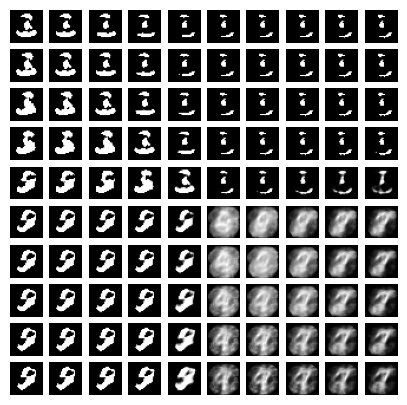

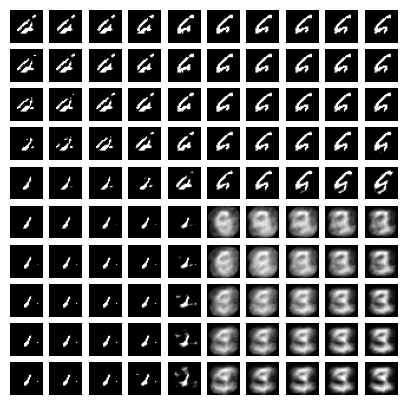

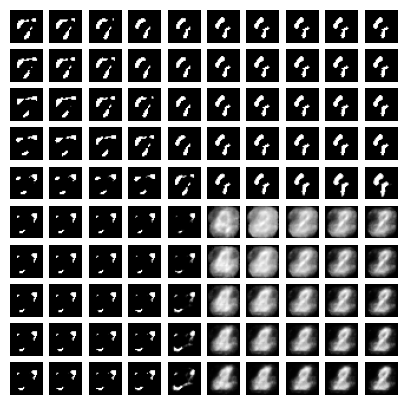

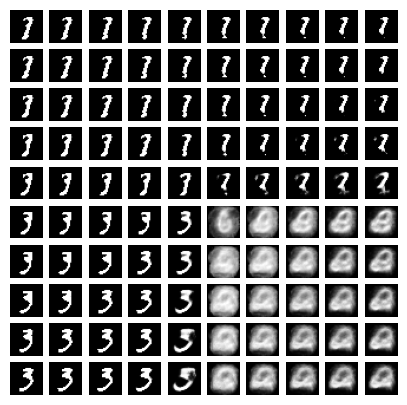

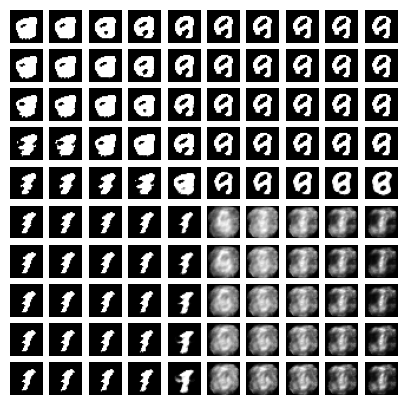

In [58]:
elem = 10
rng = 3.0

x_recon_pairs = []
for n in range(0,10,2):
    # linspace creates an array of elem elements between -range and range 
    # this means grid center is at (0,0)
    x = np.linspace(-rng, rng, elem)
    y = np.linspace(-rng, rng, elem)

    # meshgrid creates a grid of x and y
    # dstack stacks the x and y grids
    z_grid = np.zeros((elem*elem, 100)) 
    for i in range(elem):
        for j in range(elem):
            z_grid[i*elem+j, n] = x[i]
            z_grid[i*elem+j, n+1] = y[j]
        

    #print(z_grid.shape)
    z = torch.tensor(z_grid).float()
    #print(z.shape)
    z = z.to(device)
    decoder.eval()
    x_recon = decoder(z)
    x_recon_pairs.append(x_recon.cpu())
    #print(x_recon.cpu().shape)

for n in range(5):
    # Plot the results
    fig, ax = plt.subplots(elem, elem, figsize=(5, 5))
    for i in range(elem):
        for j in range(elem):
            ax[i, j].imshow(x_recon_pairs[n][i * elem + j].view(28, 28).detach(), cmap='gray')
            ax[i, j].axis('off')
plt.show()

## Closing remarks

In this Lab session we've experimented with VAE's on the MNIST dataset. We've used a simple fully connected encoder and decoder architecture. In order to get better results, it might be worthwhile exploring other architectures, in particular convolutional neural networks for encoding and decoding images. You can also easily test this on more compelling datasets that are available in `torchvision`, for example CelebA or others.

Will love to explore more. However due to work load of projects and exams. This is impossible. :(